## 1. Предварительный анализ данных

Для начала проанализируем исходный датасет, который мы сформировали<br>
В нем присутствуют почасовые данные с 2020 года<br>
Также, в датасете множество признаков

In [ ]:
import pandas as pd
import os
import polars as pl
import time
import gc
import seaborn as sns
import matplotlib.pyplot as plt

Путь к исходным данным

In [1]:
files_path = f'{'/'.join(os.getcwd().split('/')[:3])}/year_project'

NameError: name 'os' is not defined

Посмотрим на размер нашего датасета

In [ ]:
df = pl.scan_csv(f'{files_path}/csv_data/air_weather_data.csv')
(df.select(pl.len()).collect().to_numpy()[0][0], len(df.collect_schema()))

(np.uint32(140091168), 53)

Видим, что в датасете более 140 млн строк и 53 показателя<br>
Необходимо понять, есть все ли данные нам нужны для модели<br>
Начнем анализ с того, что посмотрим какие показатели у нас есть, к какому типу они относятся и есть ли в них пропуски<br>
Датасет очень большой, поэтому исследуем часть датасета

In [ ]:
df.collect_schema()

Schema([('date', String),
        ('temperature_2m', Float64),
        ('relative_humidity_2m', Float64),
        ('rain', Float64),
        ('snowfall', Float64),
        ('snow_depth', Float64),
        ('surface_pressure', Float64),
        ('cloud_cover', Float64),
        ('wind_speed_10m', Float64),
        ('wind_direction_10m', Float64),
        ('year', Int64),
        ('quarter', Int64),
        ('month', Int64),
        ('day', Int64),
        ('hour', Int64),
        ('city_id', Int64),
        ('city_name', String),
        ('region', String),
        ('lat', Float64),
        ('lon', Float64),
        ('pm10', Float64),
        ('pm2_5', Float64),
        ('carbon_monoxide', Float64),
        ('carbon_dioxide', String),
        ('nitrogen_dioxide', Float64),
        ('sulphur_dioxide', Float64),
        ('ozone', Float64),
        ('alder_pollen', String),
        ('birch_pollen', String),
        ('grass_pollen', String),
        ('mugwort_pollen', String),
        ('oli

In [ ]:
pl.read_csv(f'{files_path}/csv_data/air_weather_data.csv', n_rows=10000000).describe()

shape: (9, 54)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ date      ┆ temperatu ┆ relative_ ┆ … ┆ number of ┆ number of ┆ respirato ┆ circulat │
│ ---       ┆ ---       ┆ re_2m     ┆ humidity_ ┆   ┆ pollutant ┆ events to ┆ ry        ┆ ory      │
│ str       ┆ str       ┆ ---       ┆ 2m        ┆   ┆ sources   ┆ reduce    ┆ diseases  ┆ system   │
│           ┆           ┆ f64       ┆ ---       ┆   ┆ ---       ┆ emi…      ┆ ---       ┆ diseases │
│           ┆           ┆           ┆ f64       ┆   ┆ f64       ┆ ---       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 10000000  ┆ 1e7       ┆ 1e7       ┆ … ┆ 1e7       ┆ 1e7       ┆ 1e7       ┆ 1e7      │
│ null_coun ┆ 0         ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ 6.753854  ┆ 75.823611 ┆ … ┆ 53865.304 ┆ 139.43460 ┆ 6734.6181 ┆ 3140.460 │
│           ┆           ┆           ┆           ┆   ┆ 324       ┆ 9         ┆ 5         ┆ 223      │
│ std       ┆ null      ┆ 10.824521 ┆ 16.654036 ┆ … ┆ 38607.987 ┆ 138.57115 ┆ 2765.6719 ┆ 1304.259 │
│           ┆           ┆           ┆           ┆   ┆ 159       ┆ 1         ┆ 01        ┆ 649      │
│ min       ┆ 2020-01-0 ┆ -33.8235  ┆ 8.700393  ┆ … ┆ 6022.0    ┆ 0.0       ┆ 1957.81   ┆ 851.14   │
│           ┆ 1 00:00:0 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 0+00:00   ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ null      ┆ -0.5475   ┆ 64.981606 ┆ … ┆ 20356.0   ┆ 14.0      ┆ 4502.4    ┆ 2197.65  │
│ 50%       ┆ null      ┆ 6.3475    ┆ 79.896484 ┆ … ┆ 41944.0   ┆ 51.0      ┆ 7491.63   ┆ 3483.06  │
│ 75%       ┆ null      ┆ 15.191    ┆ 89.43343  ┆ … ┆ 92507.756 ┆ 250.0     ┆ 8104.5    ┆ 3969.77  │
│ max       ┆ 2021-12-3 ┆ 38.041    ┆ 100.0     ┆ … ┆ 274789.0  ┆ 333.0     ┆ 13121.39  ┆ 7241.6   │
│           ┆ 1 23:00:0 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 0+00:00   ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [ ]:
chunk = pl.read_csv(f'{files_path}/csv_data/air_weather_data.csv', n_rows=1000000)
chunk = pd.DataFrame(chunk, columns=chunk.columns)
chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 53 columns):
 #   Column                                Non-Null Count    Dtype 
---  ------                                --------------    ----- 
 0   date                                  1000000 non-null  object
 1   temperature_2m                        1000000 non-null  object
 2   relative_humidity_2m                  1000000 non-null  object
 3   rain                                  1000000 non-null  object
 4   snowfall                              1000000 non-null  object
 5   snow_depth                            1000000 non-null  object
 6   surface_pressure                      1000000 non-null  object
 7   cloud_cover                           1000000 non-null  object
 8   wind_speed_10m                        1000000 non-null  object
 9   wind_direction_10m                    1000000 non-null  object
 10  year                                  1000000 non-null  object
 11 

Видим, что есть столбцы, которые можно убрать из датасета, так как они дублируют друг друга<br>
date - так как дата представлена в виде года, квартала, месяца, дня и часа<br>
city_name - так как у нас есть city_id<br>

Также, у нас есть столбцы с пропусками:<br>
forest area - данные представлены не по всем годам<br>
Показатели пыльцы - в случае, если данные отсутствуют, то в этот период пыльцы не наблюдалось и значение можно заменить на 0<br>
formaldehyde - не все датчики факсируют этот показатель, поэтому данные могут быть неполные. В этом случае, лучше заполнить пропуски медианой<br>
carbon dioxide - в выбранном периоде данные по нему могут отсутствовать, можем заменить медианой

Посмотрим на корреляционную матрицу<br>
Датасет очень большой для анализа и поэтому необходимо посмотреть на признаки, которые больше всего влияют на целевые переменные<br>
Также, между признаками может быть мультиколлинеарность, от которой необходимо избавиться

In [ ]:
def correlation(path, size):
    chunk = pl.read_csv(path, n_rows=size)
    columns = []
    for col in chunk.columns:
        try: 
            chunk = chunk.with_columns(pl.col(col).cast(pl.Float64))
            columns.append(col)
        except Exception:
            continue

    chunk = chunk.select(columns)

    for col in chunk:
        median_value = chunk[col.name].median()
        chunk = chunk.with_columns(pl.when(pl.col(col.name).is_null()).then(median_value).otherwise(pl.col(col.name)).alias(col.name))

    sns.set(font_scale=0.6)

    plt.figure(figsize=(20, 8))
    sns.heatmap(chunk.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, xticklabels=chunk.columns, yticklabels=chunk.columns)

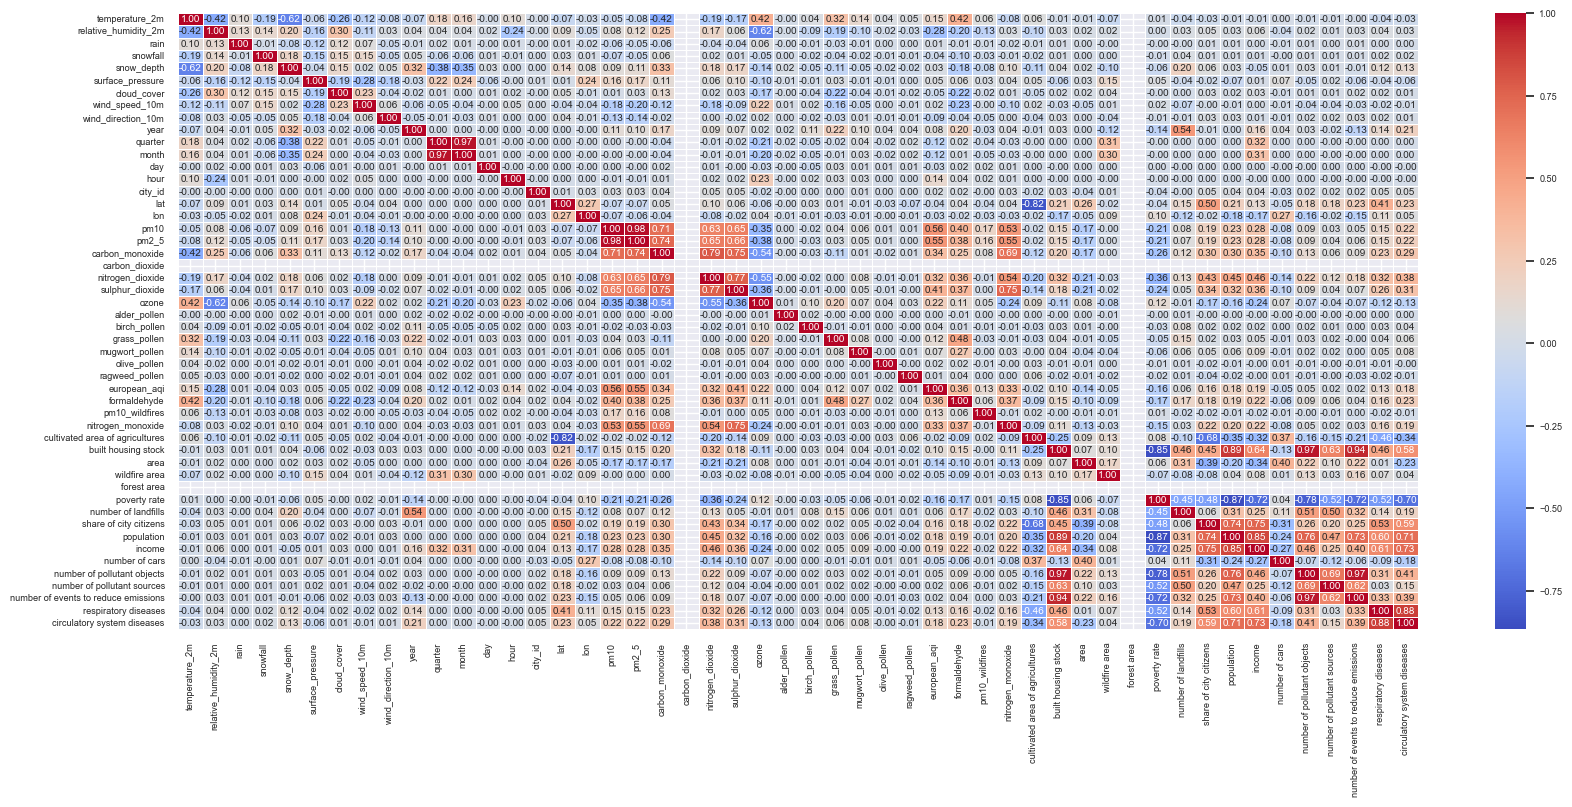

In [ ]:
correlation(f'{files_path}/csv_data/air_weather_data.csv', 30000000)

Видим, что на european_aqi влияет множество загрязнителей воздуха, такие как pm10, carbon_monoxide и другие<br>
Также можно заметить, что между социально-экономическими показателями существует сильная корреляция. Это также связано с тем, что многие из этих данных представлены по годам<br>
В таком случае, они не будут оказывать сильного влияния на целевые переменные и их можно убрать

## 2. Преобразование датасета

Оставим в датасете только те показатели, которые мы будем использовать в модели<br>
1. Убираем признаки с низкой корреляцией
2. Убираем признаки с большой долей пропусков
3. Обучаем модель с L1-регуляризацией на подвыборке и смотрим на коэффициенты модели, убираем признаки с низким значением (обучение происходит в base_model/train_model.py)

Также, агрегируем данные по дням, так как в исходном датасете данные представлены по часам, что является очень глубокой детализацией

In [ ]:
def save_df(df, filename):
    if not os.path.isfile(filename):
        df.to_csv(filename, mode='w', header=True, index=False)
    else:
        df.to_csv(filename, mode='a', header=False, index=False)

def transform_dataset(chunksize):
    total_rows = 0

    while True:
        chunk = pl.read_csv(f'{files_path}/csv_data/air_weather_data.csv', skip_rows=total_rows, n_rows=chunksize)

        if total_rows == 0:
            columns = chunk.columns
        else:
            chunk.columns = columns

        if chunk.is_empty():
            break

        total_rows += chunk.shape[0]

        chunk_updated_without_pollen = chunk.select([
            'date', 'year', 'month', 'day', 'hour', 'region', 'city_name', 'city_id', 
            'lat', 'lon', 'european_aqi', 'temperature_2m', 'relative_humidity_2m', 
            'rain', 'snowfall', 'snow_depth', 'cloud_cover', 'wind_speed_10m', 
            'wind_direction_10m', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide', 
            'sulphur_dioxide', 'ozone', 'nitrogen_monoxide', 'population', 'income'
        ])

        chunk_updated_without_pollen = chunk_updated_without_pollen.filter(
            (pl.col('date') <= '2024-10-15')
        )

        chunk_updated_without_pollen = chunk_updated_without_pollen.group_by(
            ['year', 'month', 'day', 'region', 'city_name', 'city_id', 'lat', 'lon']
            ).agg(pl.col(['european_aqi', 'temperature_2m', 'relative_humidity_2m',
                          'rain', 'snowfall', 'snow_depth', 'cloud_cover', 'wind_speed_10m', 
                          'wind_direction_10m', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide', 
                          'sulphur_dioxide', 'ozone', 'nitrogen_monoxide', 'population', 'income'
                          ]).mean())

        chunk_updated_without_pollen = pd.DataFrame(chunk_updated_without_pollen, columns=chunk_updated_without_pollen.columns)
        save_df(chunk_updated_without_pollen, f'{files_path}/csv_data/air_weather_data_lite.csv')

        print(f'{total_rows} rows processed')

In [ ]:
transform_dataset(20000000)

20000000 rows processed
40000000 rows processed
60000000 rows processed
80000000 rows processed
100000000 rows processed
120000000 rows processed
140000000 rows processed
140091168 rows processed


При чтении из исходного файла мы могли взять часть дня. Из-за этого в air_weather_data_lite могло возникнуть 2 строки с одной датой<br>
Необходимо считать данные из файла и сгруппировать

In [ ]:
df = pl.read_csv(f'{files_path}/csv_data/air_weather_data_lite.csv')
df = df.group_by(
            ['year', 'month', 'day', 'region', 'city_name', 'city_id', 'lat', 'lon']
            ).agg(pl.col(['european_aqi', 'temperature_2m', 'relative_humidity_2m',
                          'rain', 'snowfall', 'snow_depth', 'cloud_cover', 'wind_speed_10m', 
                          'wind_direction_10m', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide', 
                          'sulphur_dioxide', 'ozone', 'nitrogen_monoxide', 'population', 'income'
                          ]).mean())
df = pd.DataFrame(df, columns=df.columns)

save_df(df, f'{files_path}/csv_data/air_weather_data_lite2.csv')

## 3. Анализ трансформированного датасета

Посмотрим на датасет с выбранными признаками

In [ ]:
df = pl.scan_csv(f'{files_path}/csv_data/air_weather_data_lite.csv')
(df.select(pl.len()).collect().to_numpy()[0][0], len(df.collect_schema()))

(np.uint32(5777678), 25)

Видим, что в итоговом датасете 5.7 млн строк и 25 признаков<br>
Часть из этих признаков будут преобразованы, так как являются категориальными, а часть убрана (например, дублирование city_name и city_id)<br>

In [ ]:
df.collect_schema()

Schema([('year', Int64),
        ('month', Int64),
        ('day', Int64),
        ('region', String),
        ('city_name', String),
        ('city_id', Int64),
        ('lat', Float64),
        ('lon', Float64),
        ('european_aqi', Float64),
        ('temperature_2m', Float64),
        ('relative_humidity_2m', Float64),
        ('rain', Float64),
        ('snowfall', Float64),
        ('snow_depth', Float64),
        ('cloud_cover', Float64),
        ('wind_speed_10m', Float64),
        ('wind_direction_10m', Float64),
        ('pm2_5', Float64),
        ('carbon_monoxide', Float64),
        ('nitrogen_dioxide', Float64),
        ('sulphur_dioxide', Float64),
        ('ozone', Float64),
        ('nitrogen_monoxide', Float64),
        ('population', Float64),
        ('income', Float64)])

In [ ]:
pl.read_csv(f'{files_path}/csv_data/air_weather_data_lite.csv').describe()

shape: (9, 26)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ year      ┆ month     ┆ day       ┆ … ┆ ozone     ┆ nitrogen_ ┆ populatio ┆ income   │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ monoxide  ┆ n         ┆ ---      │
│ str       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 5.777678e ┆ 5.777678e ┆ 5.777678e ┆ … ┆ 5.766327e ┆ 4.287073e ┆ 5.777678e ┆ 4.693967 │
│           ┆ 6         ┆ 6         ┆ 6         ┆   ┆ 6         ┆ 6         ┆ 6         ┆ e6       │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 11351.0   ┆ 1.490605e ┆ 0.0       ┆ 1.083711 │
│ t         ┆           ┆           ┆           ┆   ┆           ┆ 6         ┆           ┆ e6       │
│ mean      ┆ 2021.9106 ┆ 6.313348  ┆ 15.663817 ┆ … ┆ 54.065445 ┆ 0.916663  ┆ 4.9420e6  ┆ 46729.14 │
│           ┆ 28        ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5959     │
│ std       ┆ 1.380283  ┆ 3.375019  ┆ 8.802332  ┆ … ┆ 14.021964 ┆ 3.998632  ┆ 3.9634e6  ┆ 18568.34 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2426     │
│ min       ┆ 2020.0    ┆ 1.0       ┆ 1.0       ┆ … ┆ 0.25      ┆ 0.0       ┆ 566375.0  ┆ 23136.0  │
│ 25%       ┆ 2021.0    ┆ 3.0       ┆ 8.0       ┆ … ┆ 45.375    ┆ 0.075     ┆ 1.104008e ┆ 33470.0  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 6         ┆          │
│ 50%       ┆ 2022.0    ┆ 6.0       ┆ 16.0      ┆ … ┆ 55.75     ┆ 0.154167  ┆ 2.324205e ┆ 41438.0  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 6         ┆          │
│ 75%       ┆ 2023.0    ┆ 9.0       ┆ 23.0      ┆ … ┆ 64.125    ┆ 0.454167  ┆ 8.542257e ┆ 56986.0  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 6         ┆          │
│ max       ┆ 2024.0    ┆ 12.0      ┆ 31.0      ┆ … ┆ 117.125   ┆ 266.22083 ┆ 1.3154708 ┆ 146161.0 │
│           ┆           ┆           ┆           ┆   ┆           ┆ 3         ┆ e7        ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [6]:
df = pd.read_csv(f'{files_path}/csv_data/air_weather_data_lite.csv')

Видим, что есть пропуски в данных, их необходимо заполнить

Строки с пропусками в столбце european_aqi можем удалить

In [ ]:
df[df['european_aqi'].isna()].groupby(['city_id', 'year']).size().reset_index(name='count_missing_values')

Строки с глубиной снега заполняем 0

In [ ]:
df[df['snow_depth'].isna()].groupby(['month']).size().reset_index(name='count_missing_values')

Строки со скоростью ветра заполняем медианным значением региона по году и месяцу

In [ ]:
df[df['wind_speed_10m'].isna()].groupby(['year']).size().reset_index(name='count_missing_values')

Пропуски в поле income заполняем медианным значением по году по региону

In [ ]:
df[df['income'].isna()].groupby(['year', 'region']).size().reset_index(name='count_missing_values')

Пропуски в поле nitrogen_monoxide заполняем медианным значением по году и региону

In [ ]:
df[df['nitrogen_monoxide'].isna()].groupby(['year', 'region']).size().reset_index(name='count_missing_values')

<Axes: >

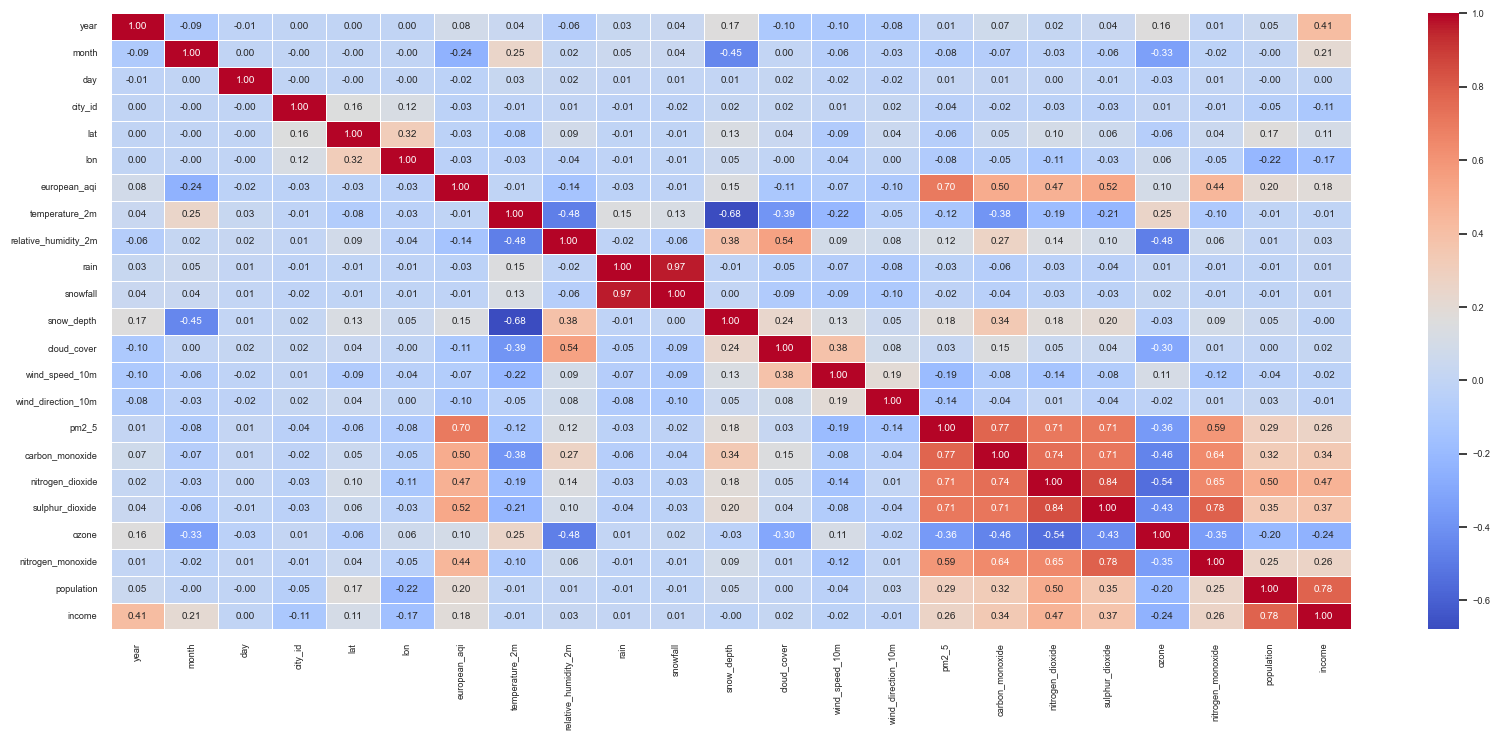

In [9]:
df_num = df.select_dtypes(['float', 'int'])

sns.set(font_scale=0.6)

plt.figure(figsize=(20, 8))
sns.heatmap(df_num.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, xticklabels=df_num.columns, yticklabels=df_num.columns)

Видим, что не все показатели имеют высокую корреляцию с целевой переменной<br>
Также видим, что существует высокая мультиколлинеарность между загрязнителями воздуха

Построим графики по регионам<br>
Сначала посмотрим данные по регионам в разрезе годов, а затем среднее значение за весь период для каждого показателя

In [27]:
def plots(column):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    sns.lineplot(data=df, x='date', y=column, hue='region', marker='o', ax=axes[0])
    axes[0].set_title(f'{column} by Region')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel(column)
    axes[0].legend(title='Region', loc='upper left', bbox_to_anchor=(1, 1)) 

    avg_aqi_by_region = df.groupby('region')[column].mean().reset_index()
    sns.barplot(data=avg_aqi_by_region, x='region', y=column, hue='region', palette='viridis', ax=axes[1], legend=False)
    axes[1].set_title(f'Average {column} by Region')
    axes[1].set_xlabel('Region')
    axes[1].set_ylabel(f'Average {column}')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

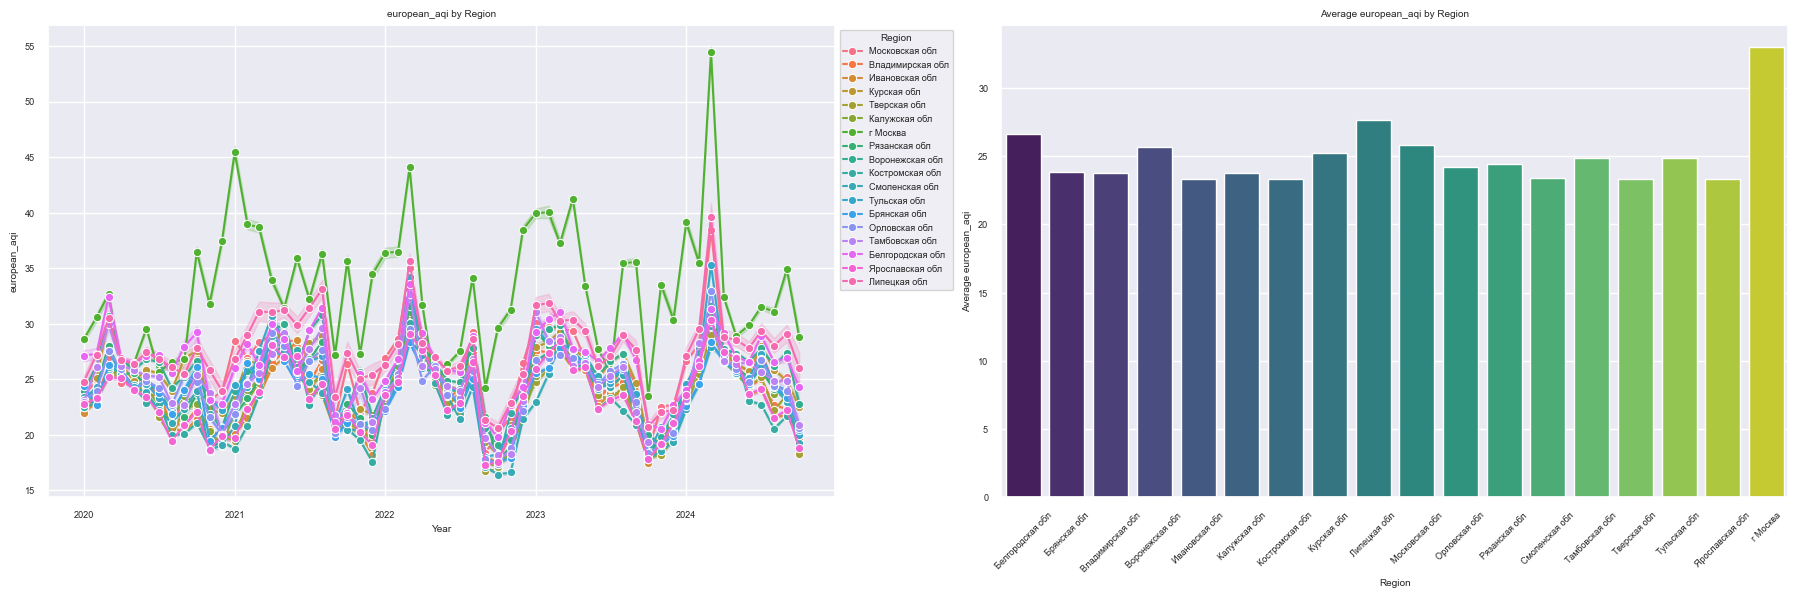

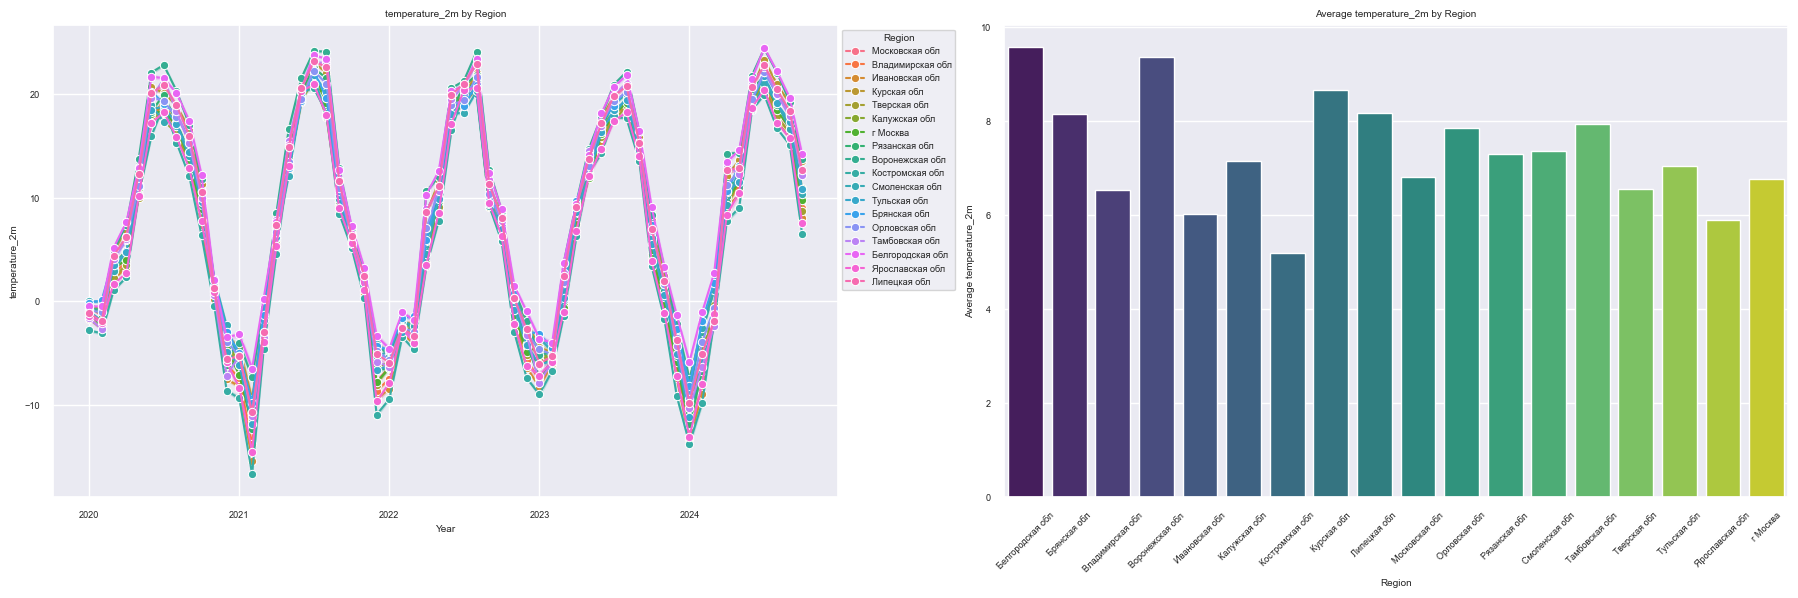

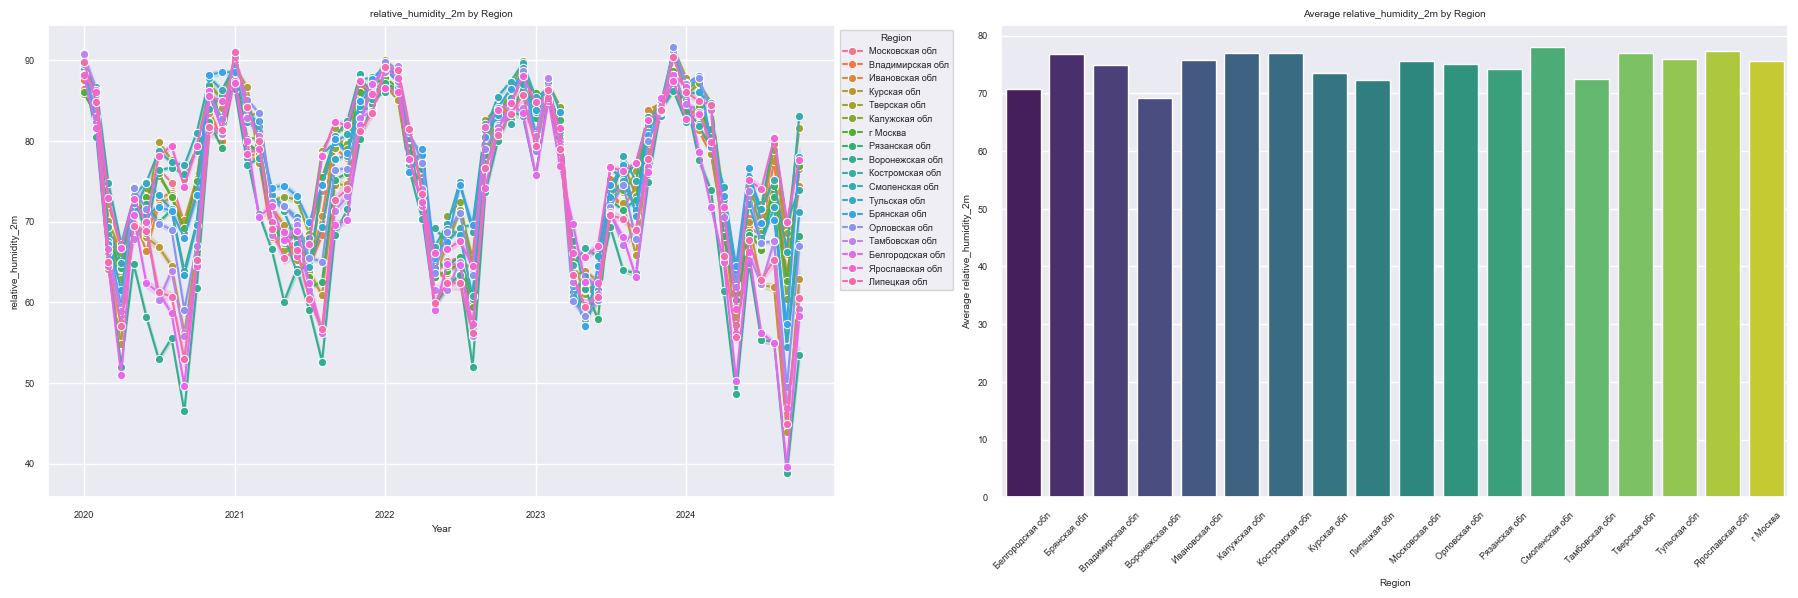

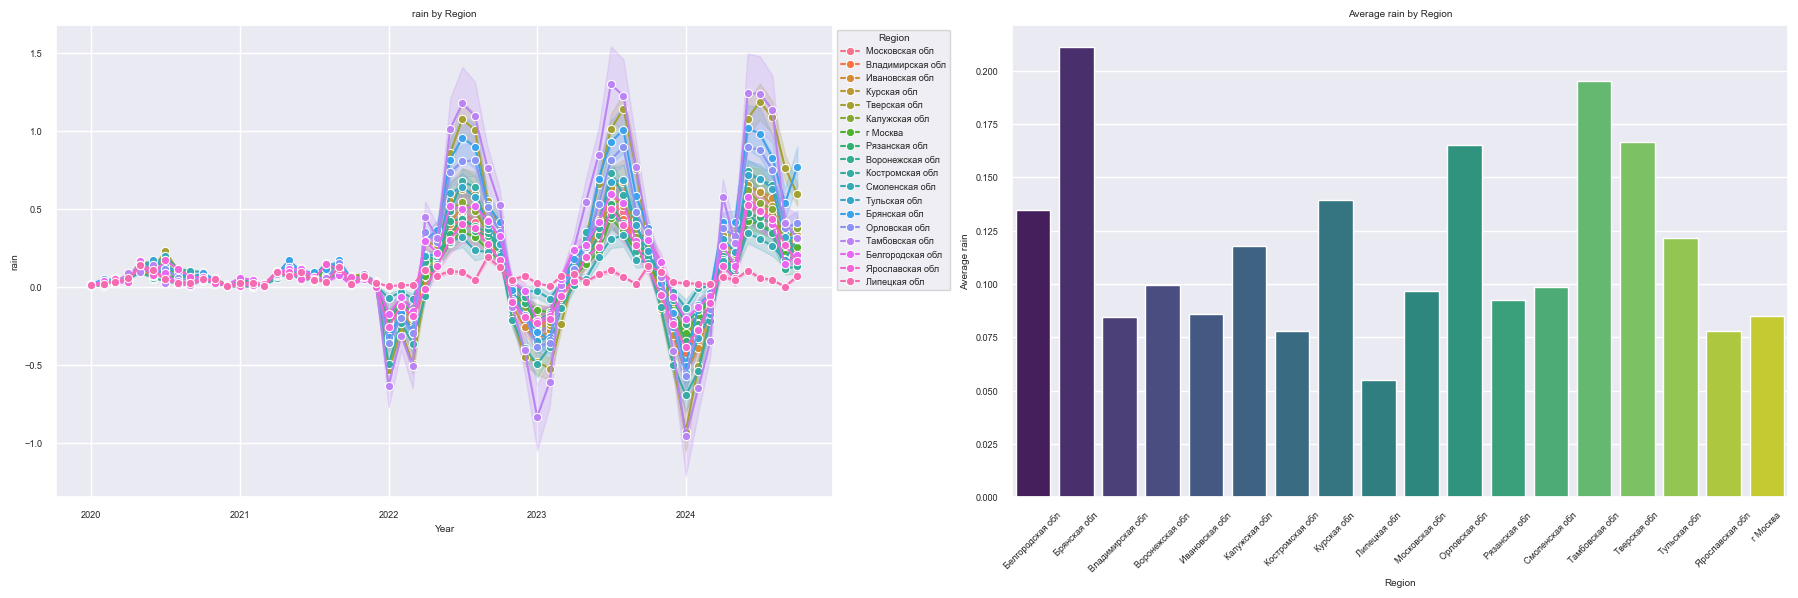

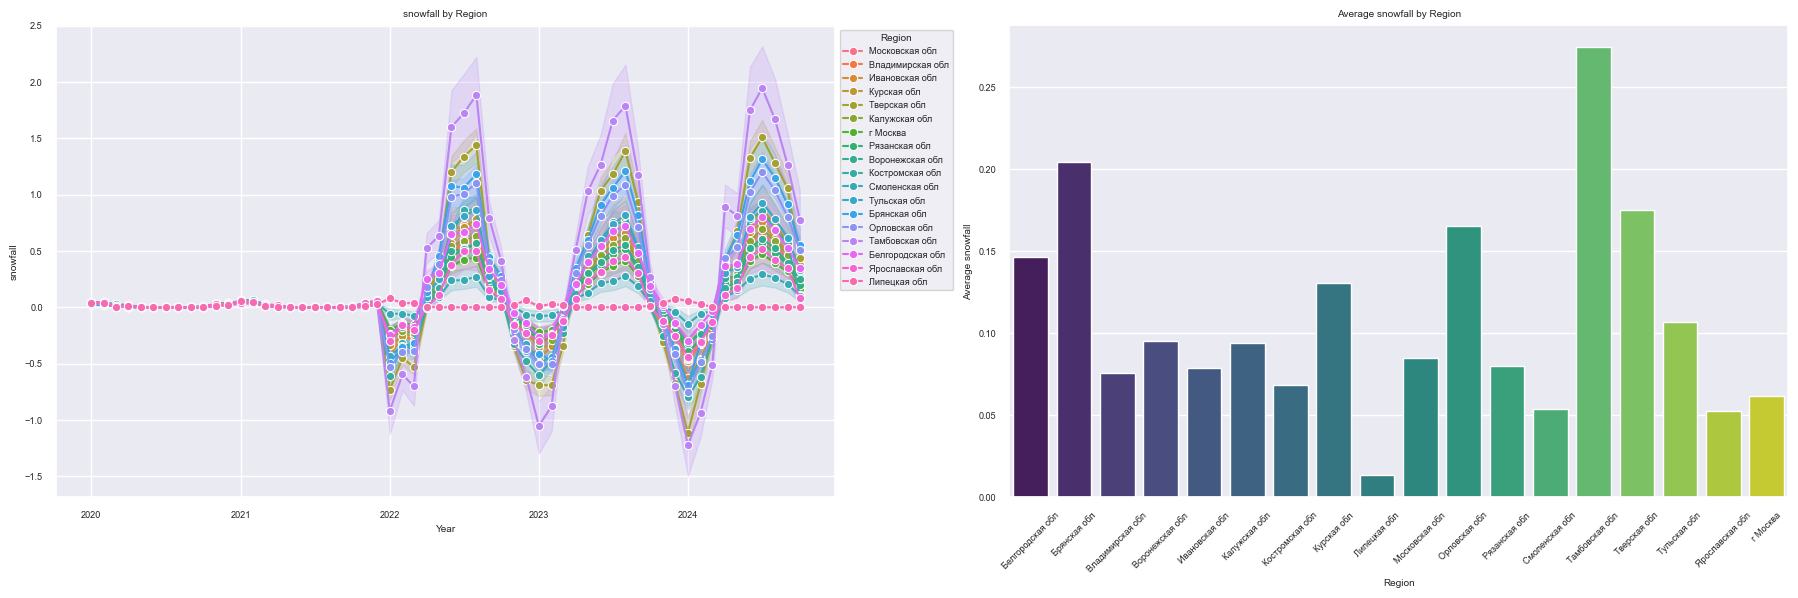

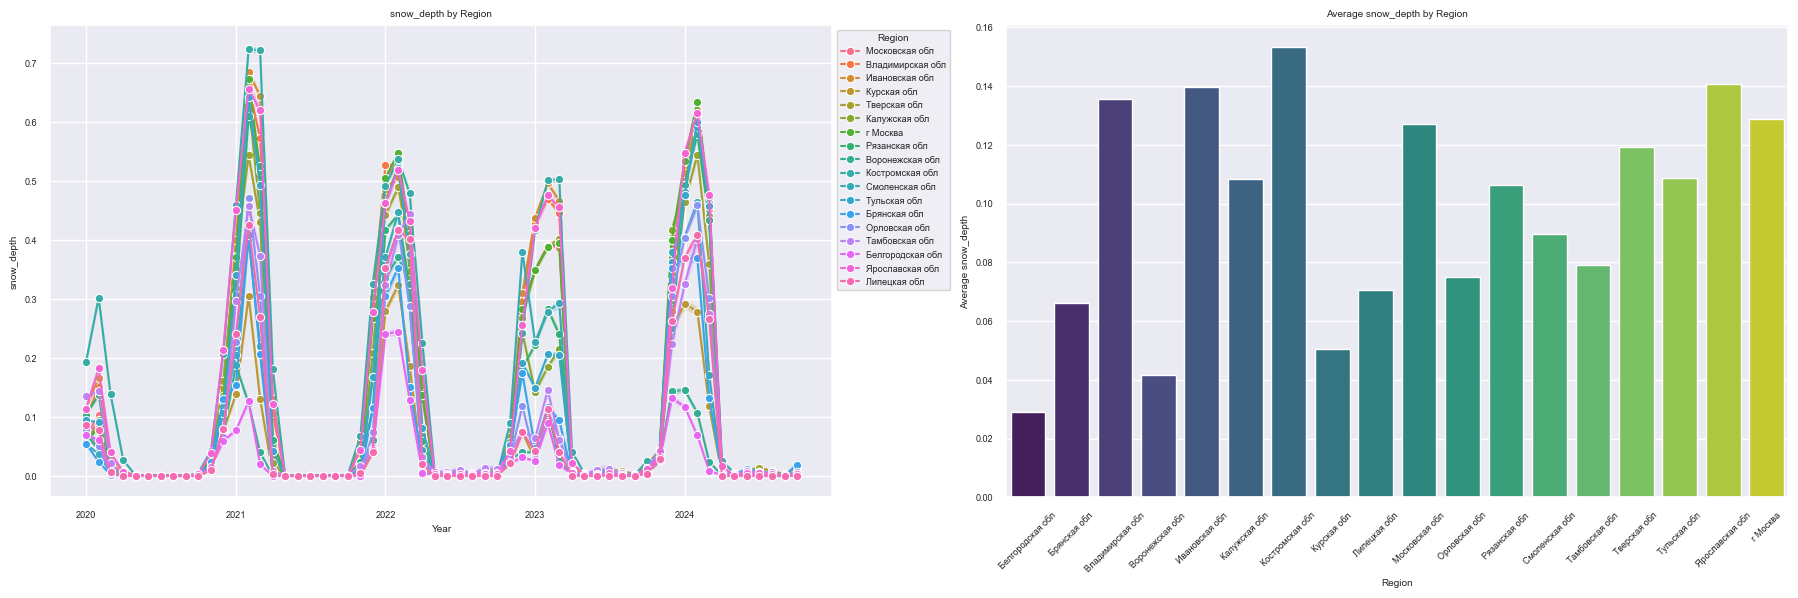

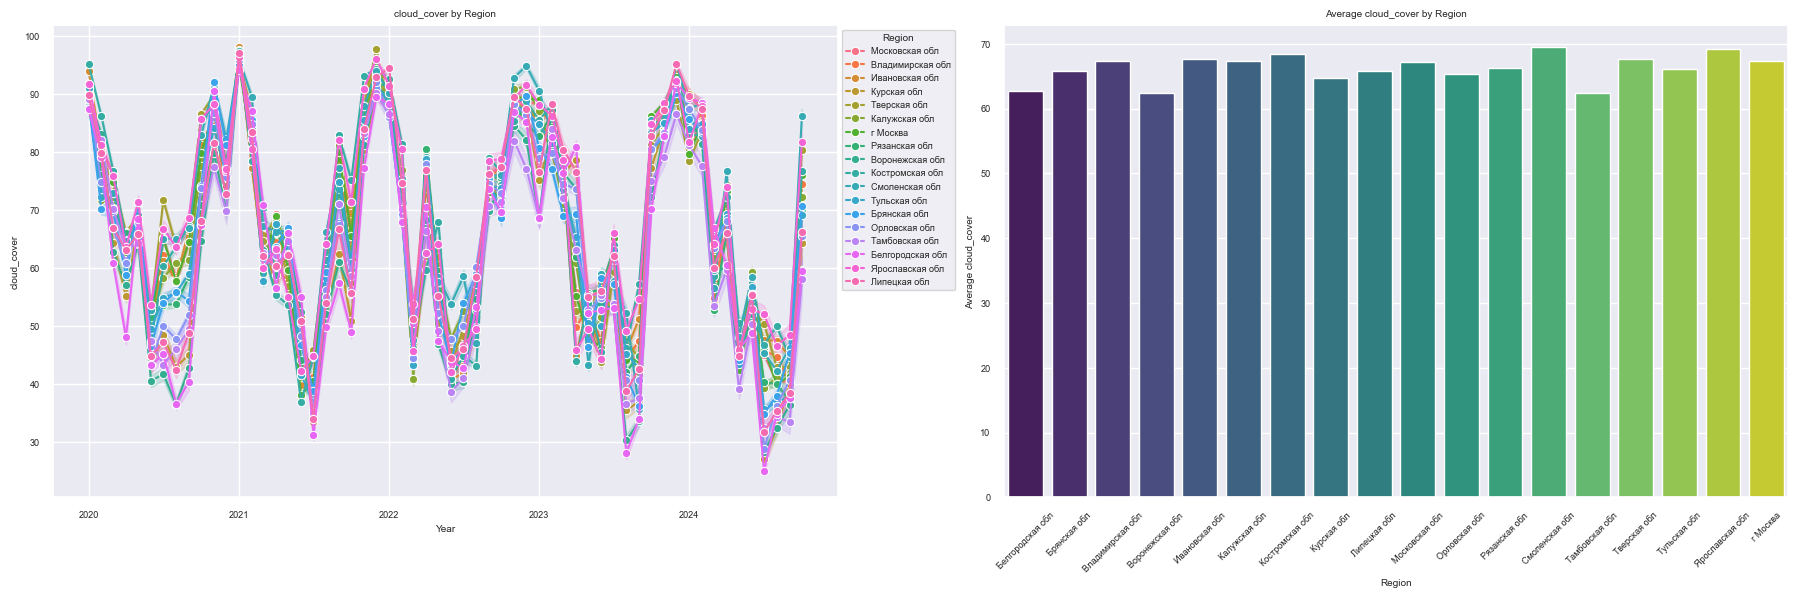

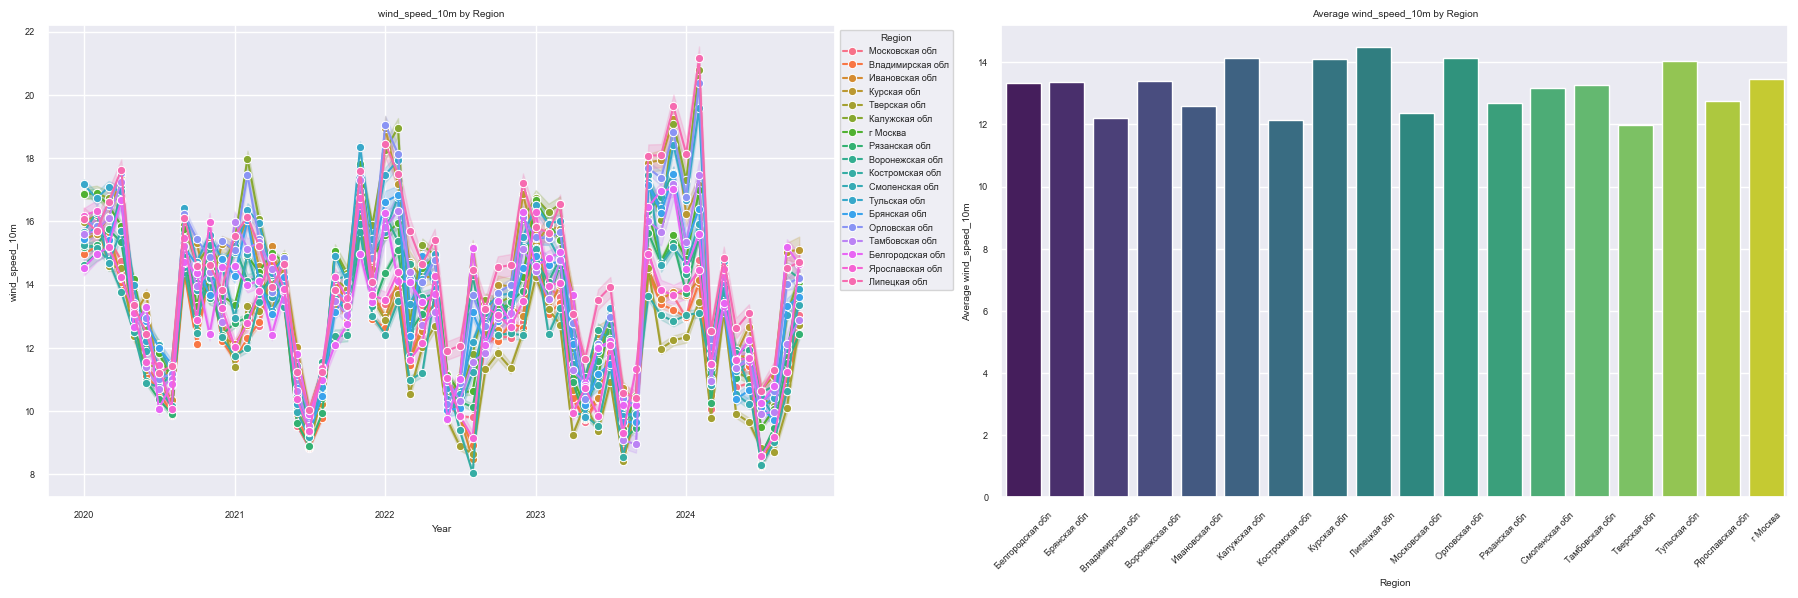

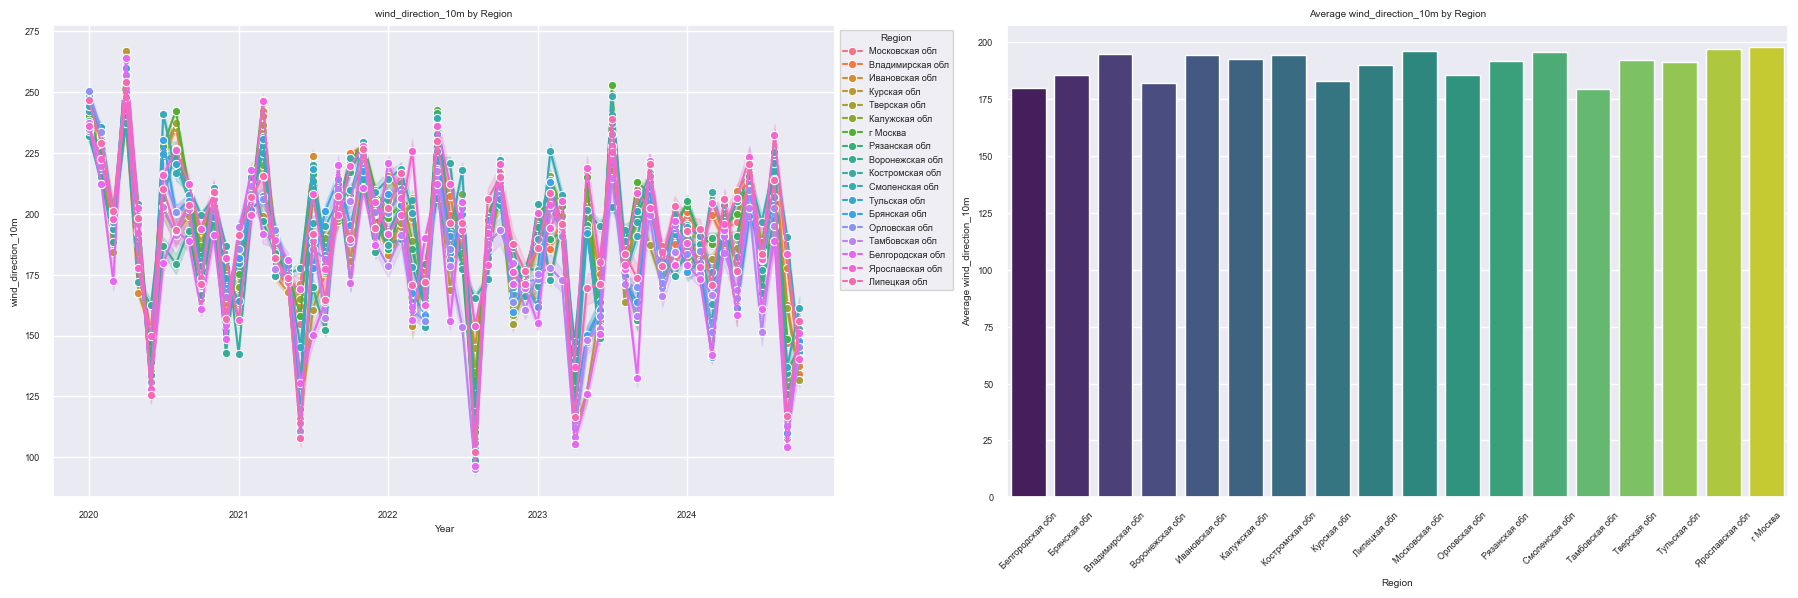

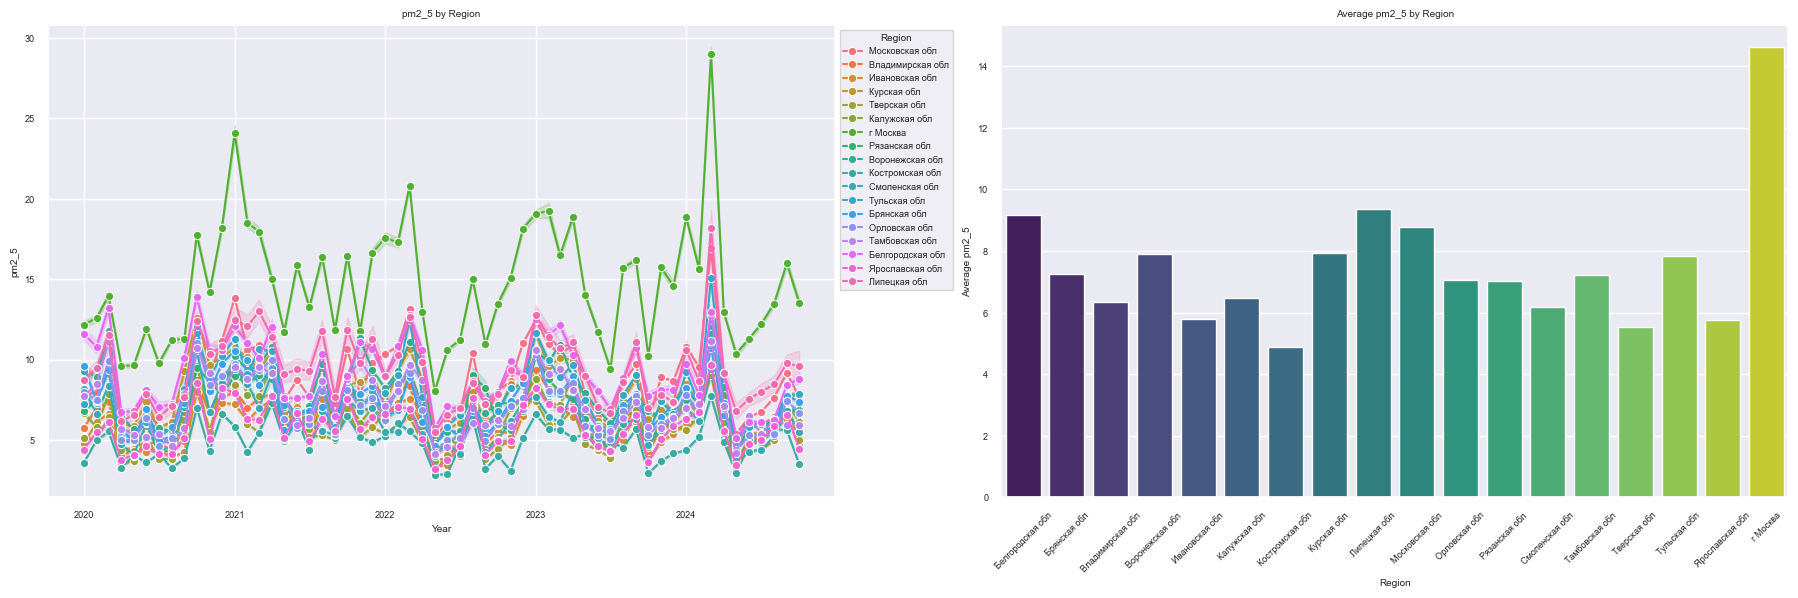

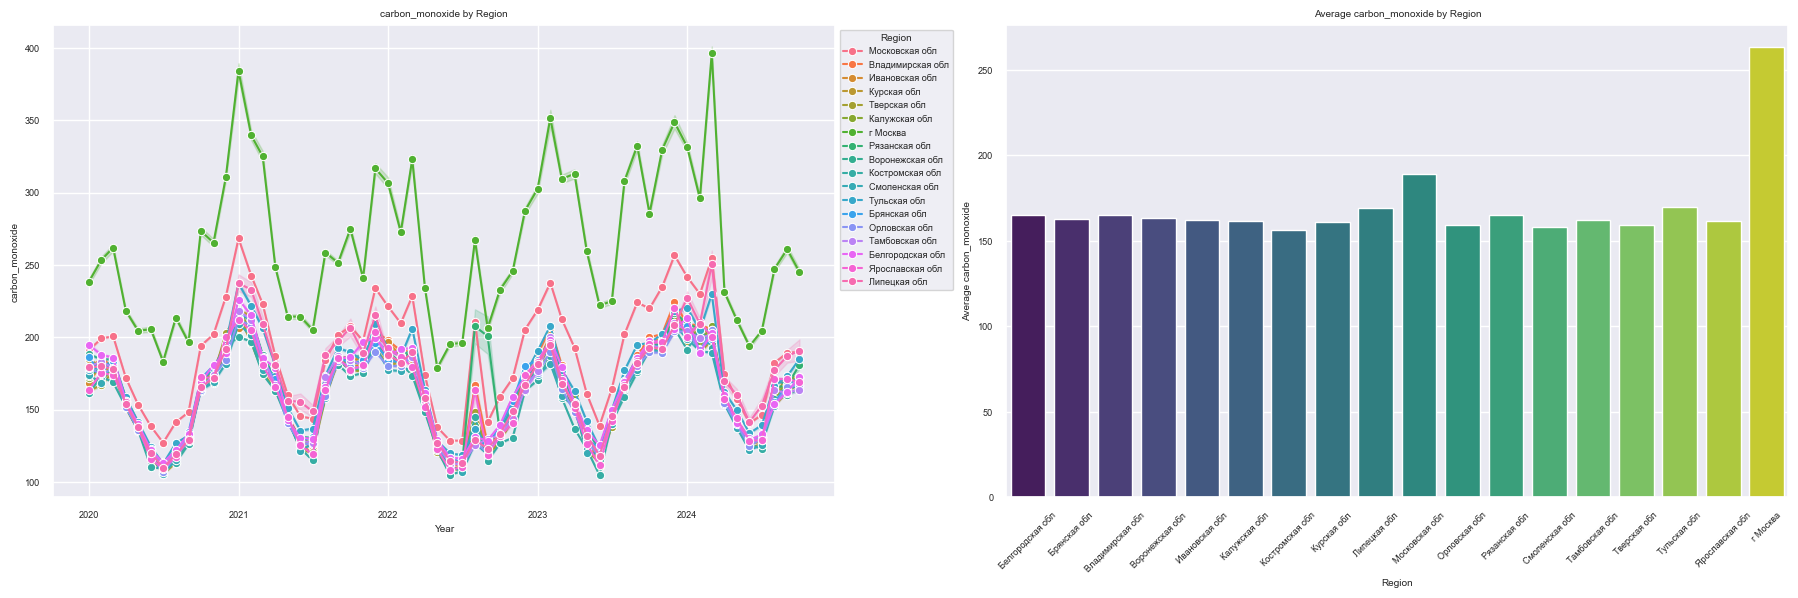

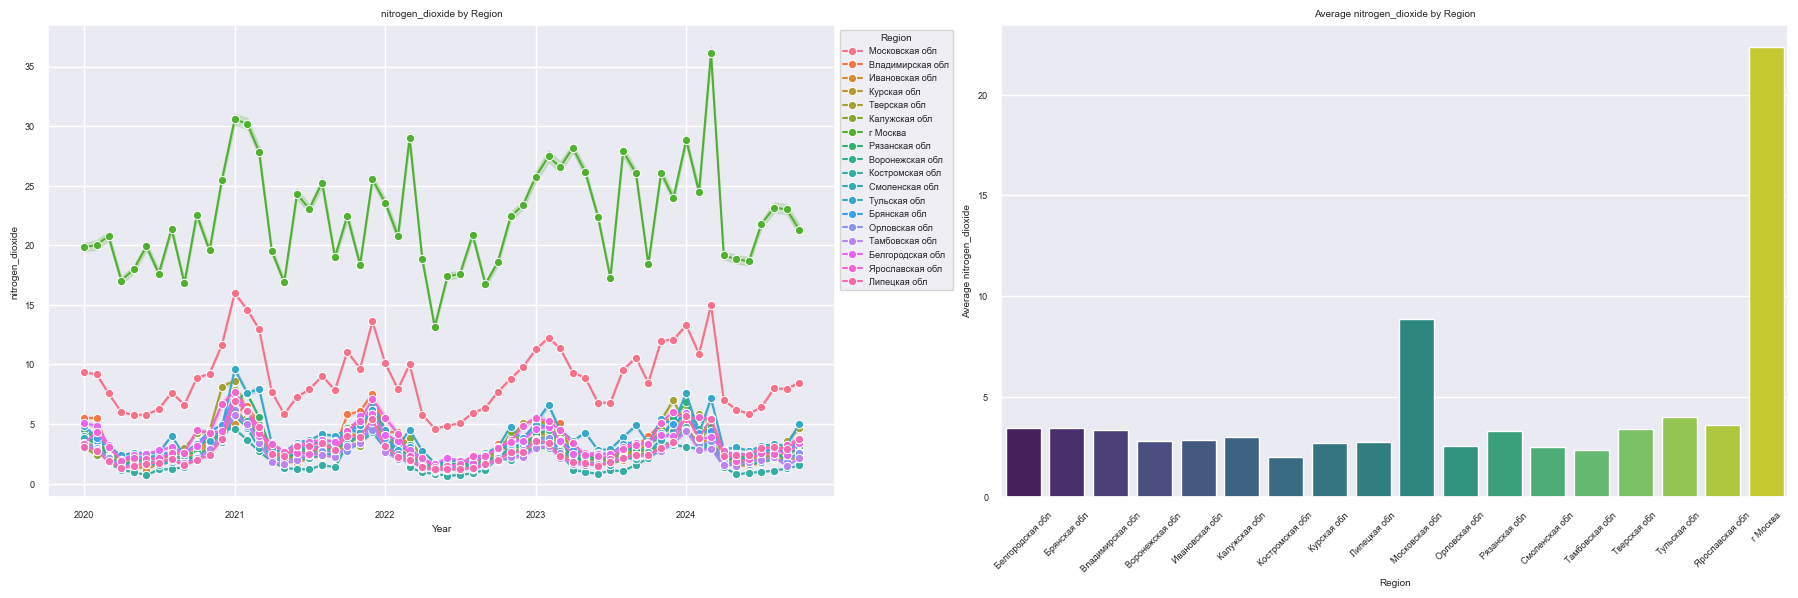

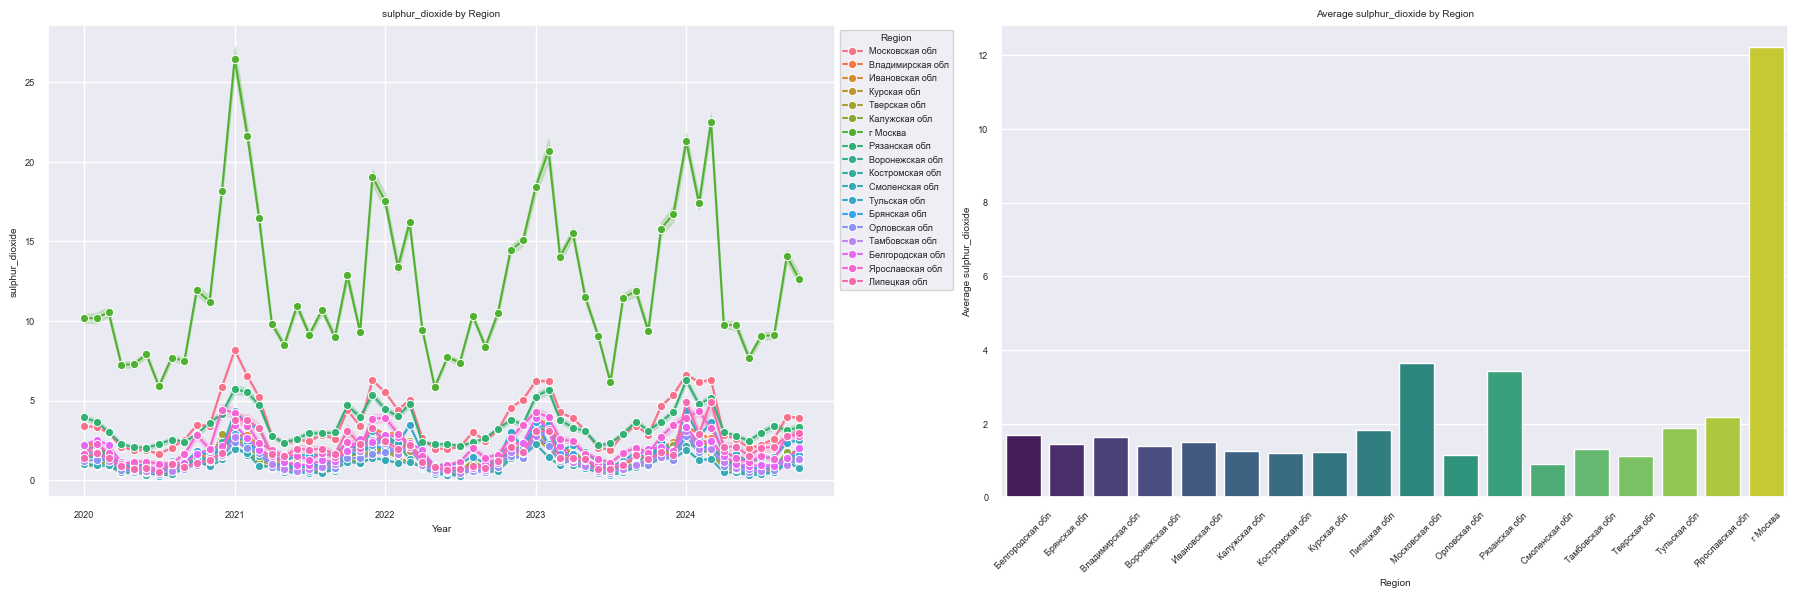

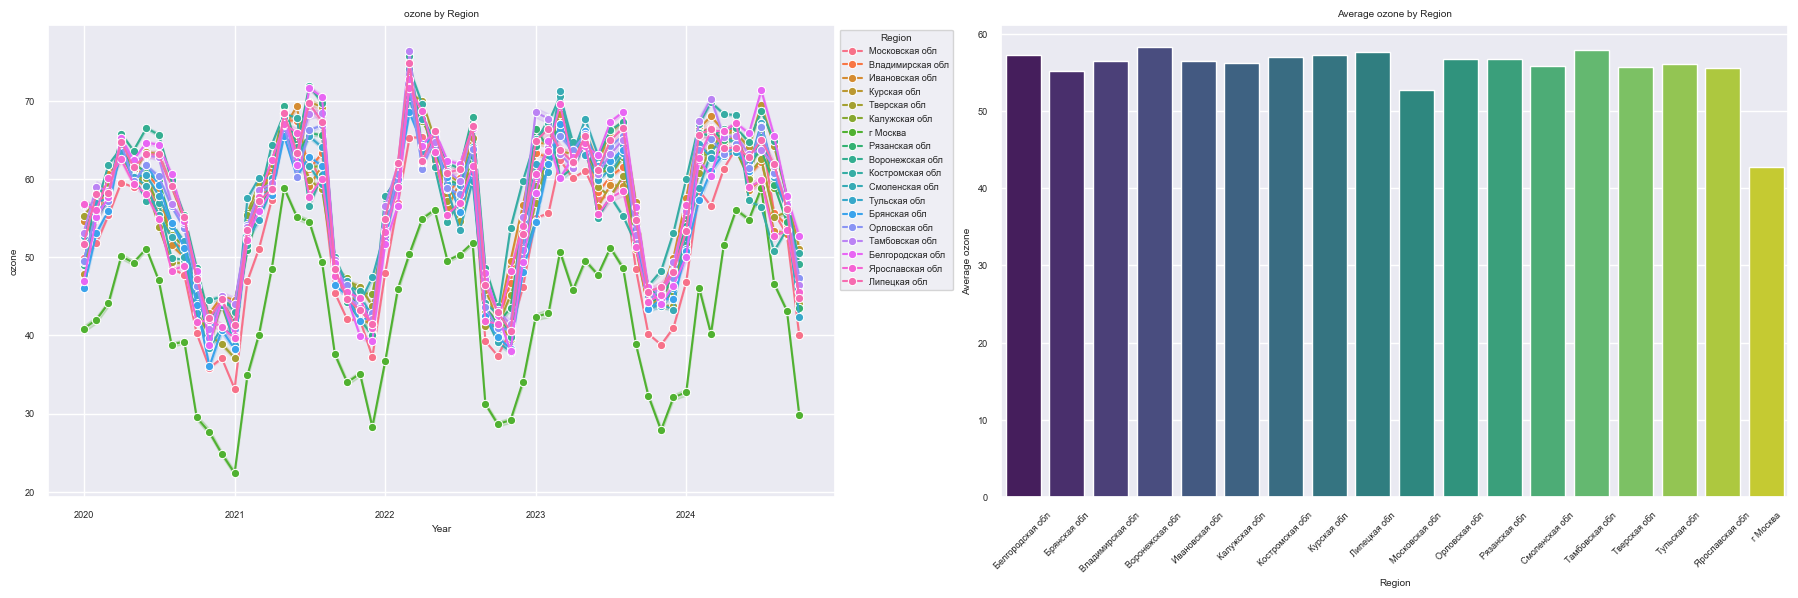

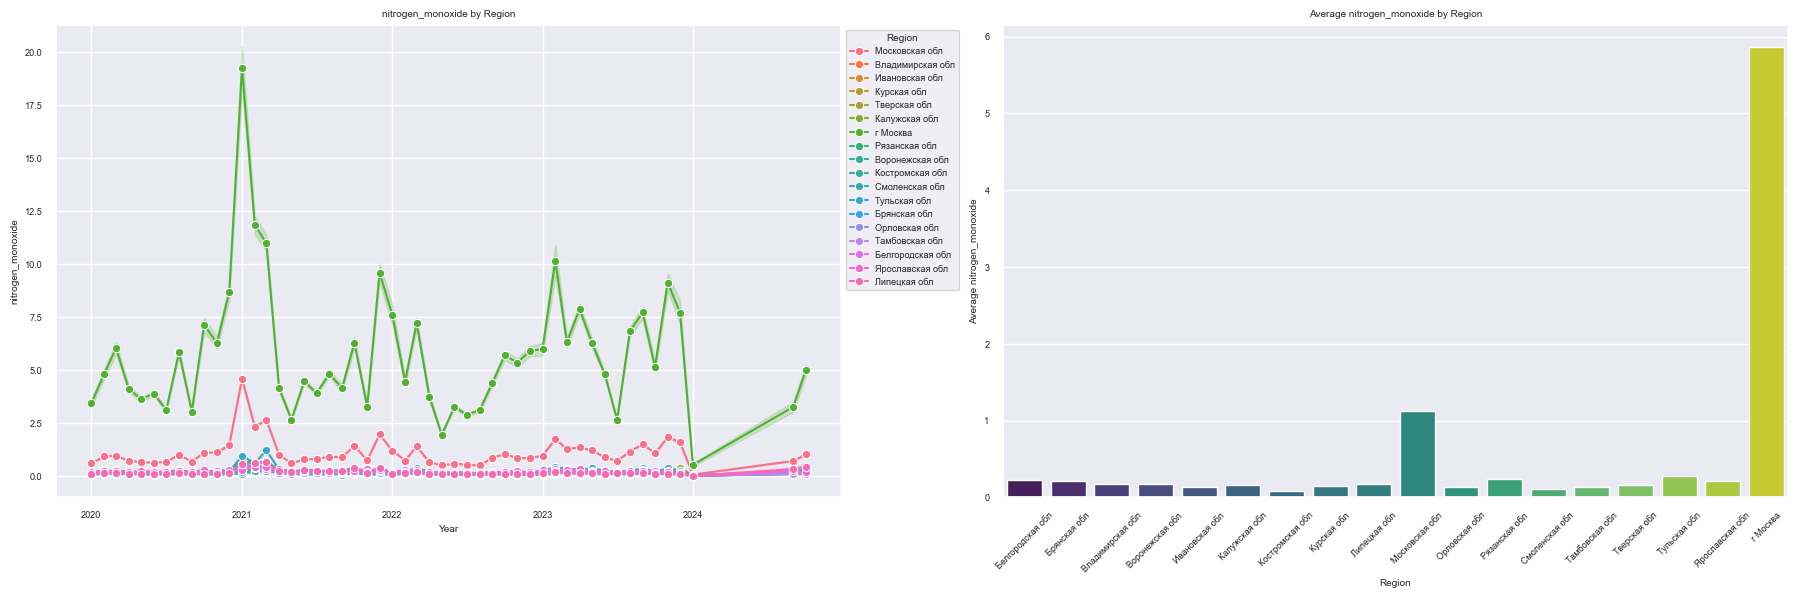

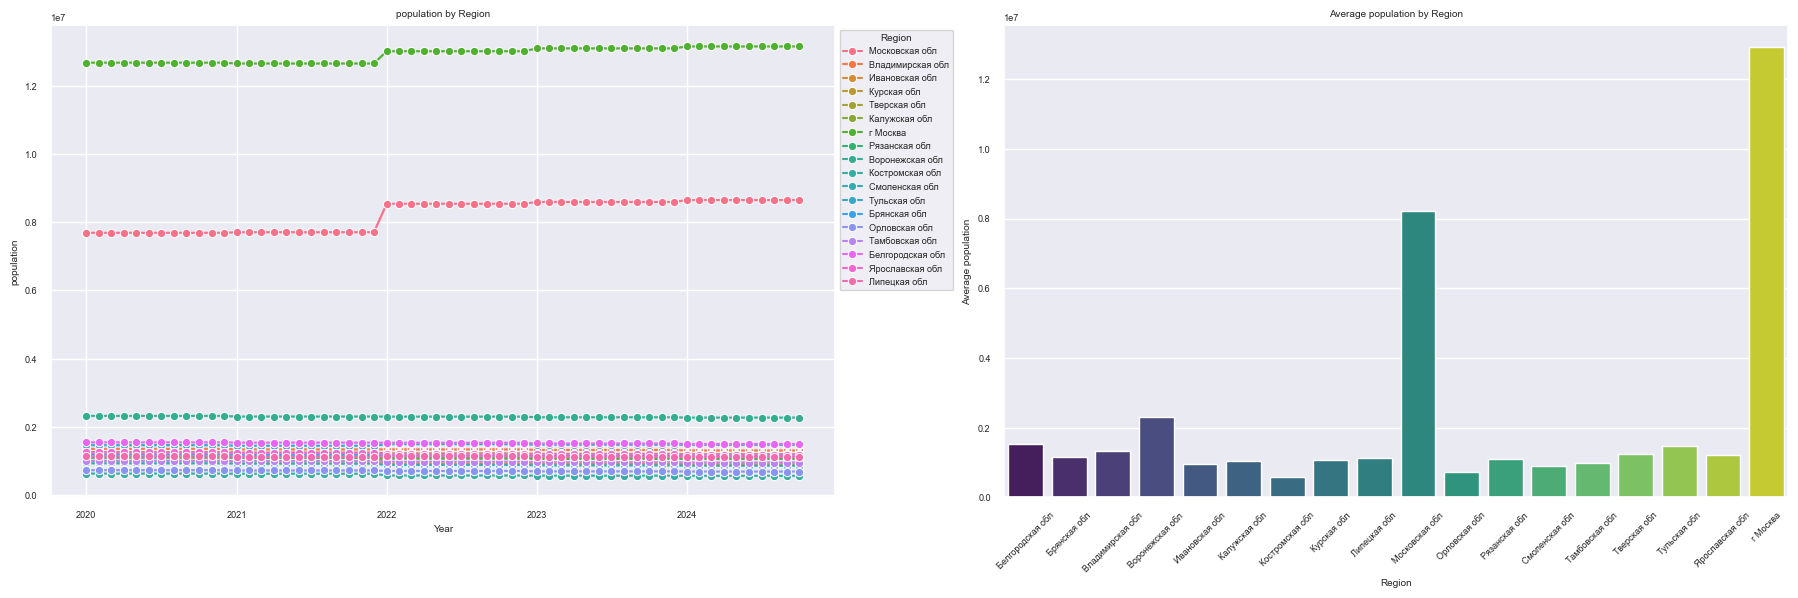

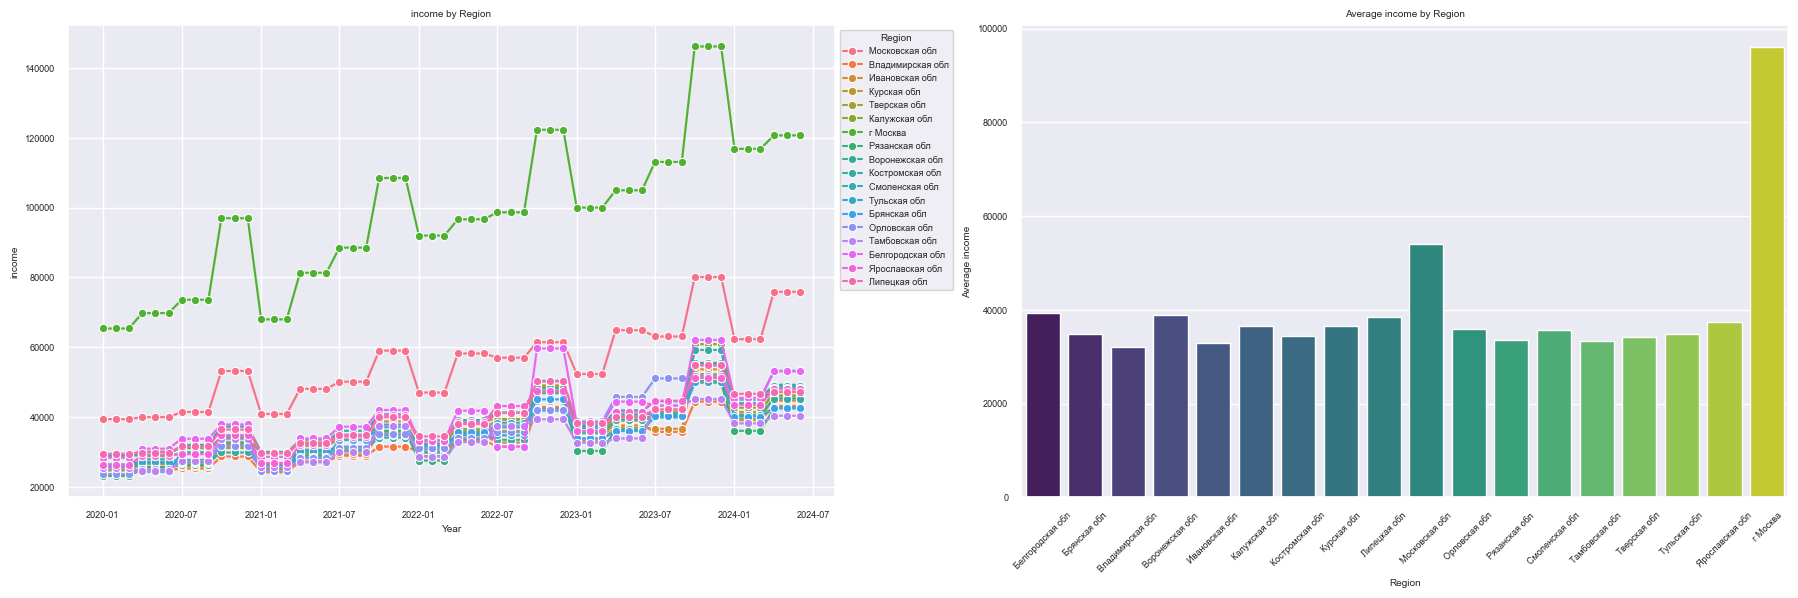

In [28]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

columns = ['european_aqi', 'temperature_2m', 'relative_humidity_2m',
           'rain', 'snowfall', 'snow_depth', 'cloud_cover', 'wind_speed_10m', 
           'wind_direction_10m', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide', 
           'sulphur_dioxide', 'ozone', 'nitrogen_monoxide', 'population', 'income']

for column in columns:
    plots(column)

Анализируя графики, можно сделать следующие выводы:<br>
Температура на высоте 2м в 2024 году была выше средних значений за прошлые 4 года<br>
Во многих регионах за период 2020-2024 гг. наблюдается тенденция к увеличению количества осадков<br>
В 2024 году cloud cover была ниже по сравнению с предыдущими 4 годами<br>
Можно заметить, что наибольшее количество выбросов приходится на Москву<br>
В 2022 году в Рязанской области был значительно выше pm10 wildfire, что могло быть вызвано лесными пожарами<br>
Также можно заметить резкий рост respiratory и circulatory diseases в Москве в 2022 году

Посмотрим наличие выделяющихся значений, построим boxplot

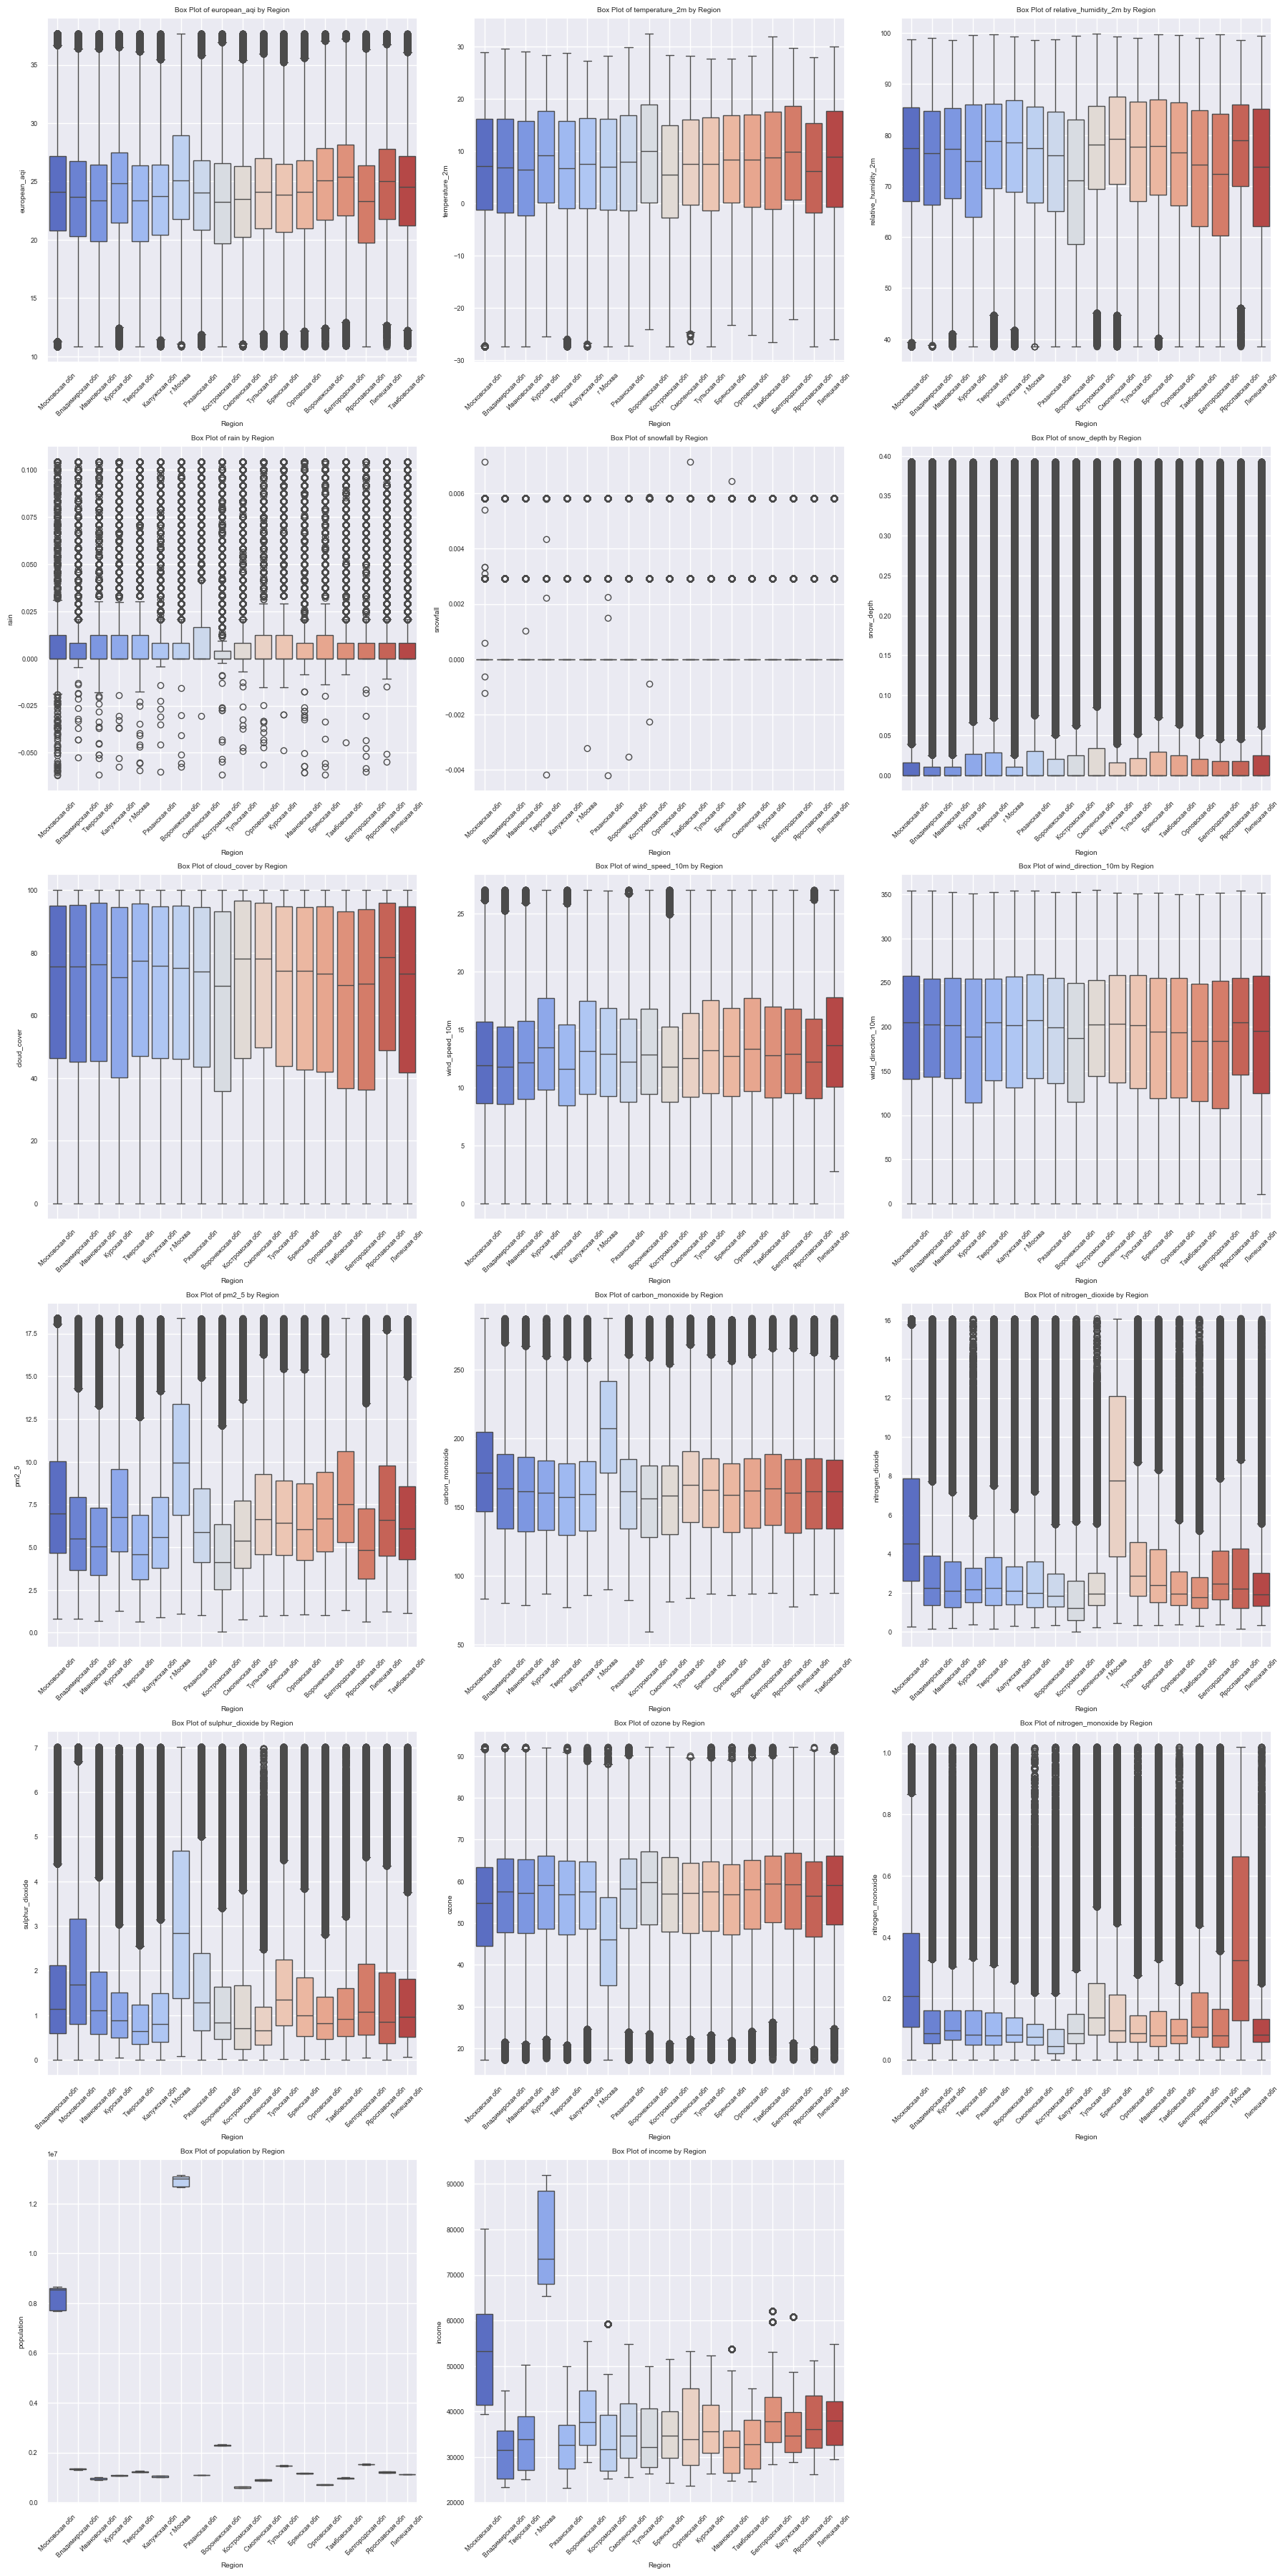

In [20]:
def boxplot(columns, row):
    for i, column in enumerate(columns):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        h = Q3 + 1.5 * IQR
        l = Q1 - 1.5 * IQR

        filtered_df = df[(df[column] <= h) & (df[column] >= l)]

        ax = axes[row, i]
        sns.boxplot(data=filtered_df, x='region', y=column, hue='region', palette='coolwarm', legend=False, ax=ax)
        ax.set_title(f'Box Plot of {column} by Region')
        ax.set_xlabel('Region')
        ax.set_ylabel(column)
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)

columns = ['european_aqi', 'temperature_2m', 'relative_humidity_2m',
           'rain', 'snowfall', 'snow_depth', 'cloud_cover', 'wind_speed_10m', 
           'wind_direction_10m', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide', 
           'sulphur_dioxide', 'ozone', 'nitrogen_monoxide', 'population', 'income']

num_columns = len(columns)
num_rows = (num_columns + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))

axes = axes.reshape(-1, 3)

for row in range(num_rows):
    start_idx = row * 3
    end_idx = start_idx + 3
    boxplot(columns[start_idx:end_idx], row)

for i in range(num_columns, num_rows * 3):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Видим, что по некоторым показателям у нас есть выделяющиеся значения<br>
Эти значения мы оставляем, так как они вызваны не некорректными данными, а погодными аномалиями

Построим scatterplot, чтобы посмотреть зависимость между показателями и целевой переменной

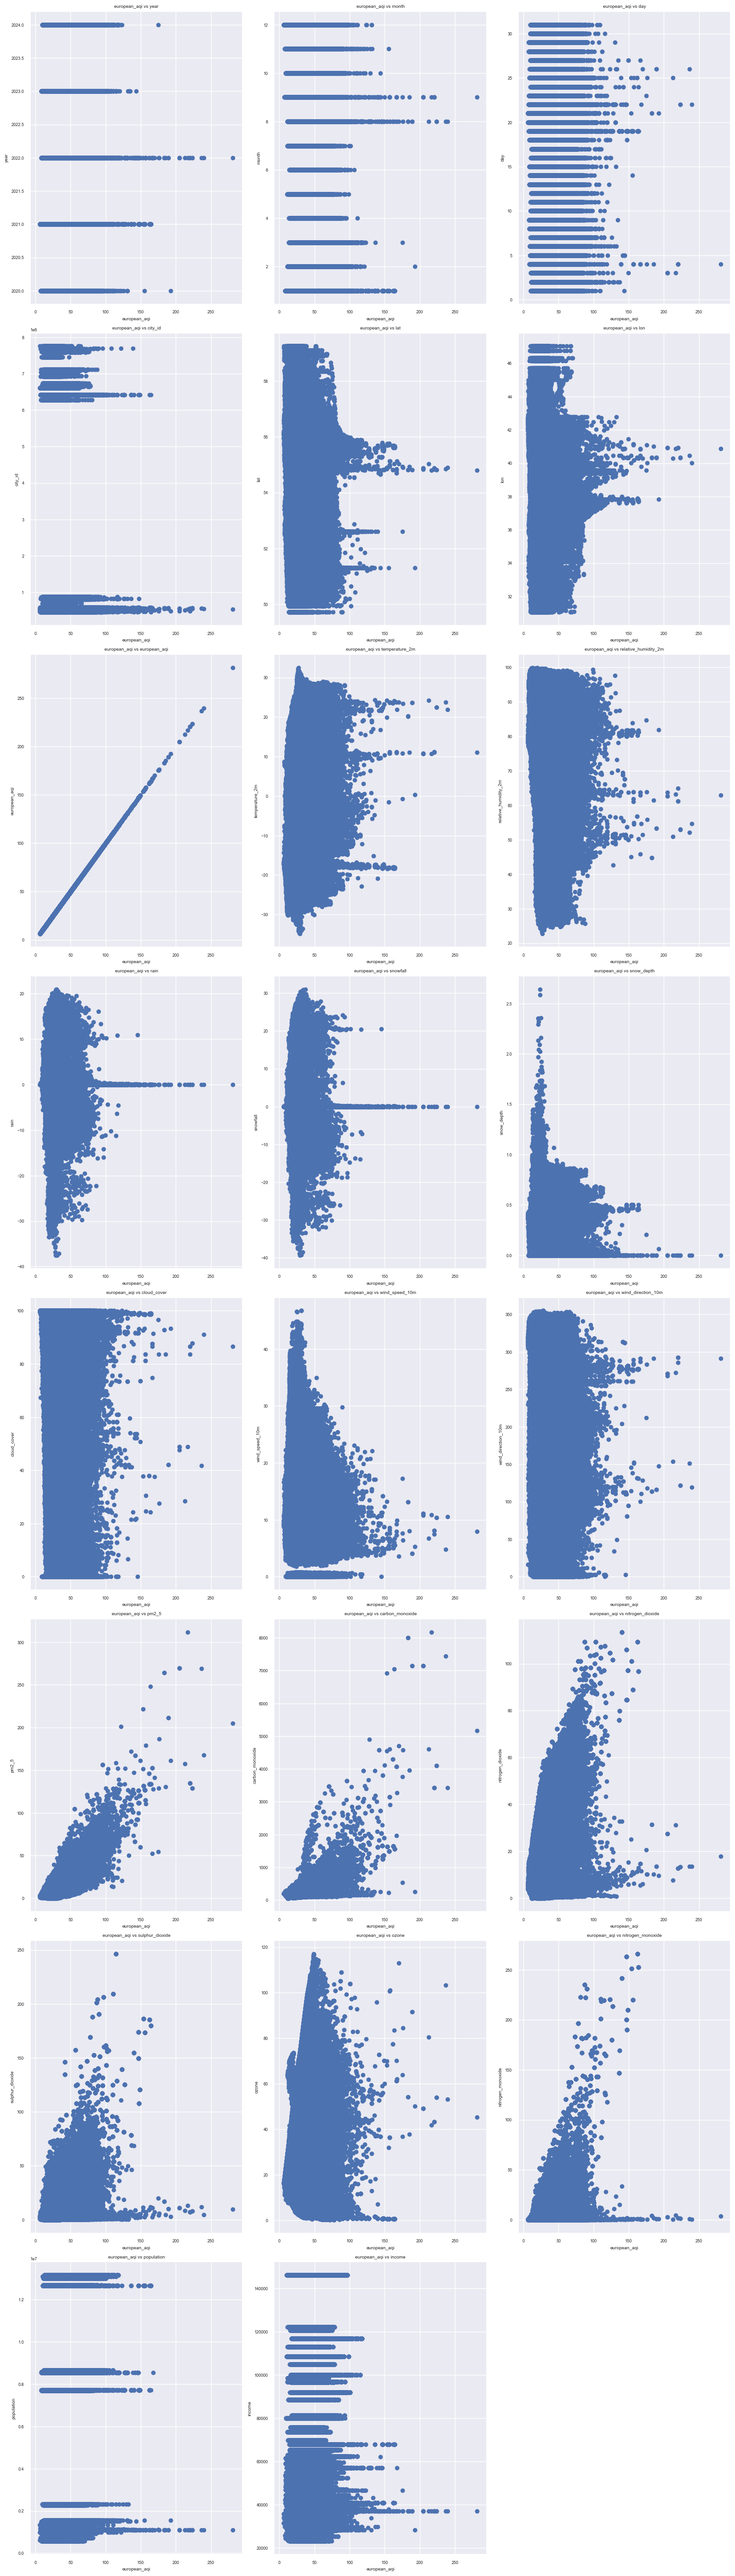

In [22]:
def make_scatter(df, ax, plot_title, xlabel, ylabel, col):
    ax.scatter(df['european_aqi'], df[col])
    ax.set_title(plot_title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

numeric_cols = df.select_dtypes([int, float]).columns
num_cols = len(numeric_cols)
fig, axes = plt.subplots(nrows=(num_cols // 3) + (num_cols % 3 > 0), ncols=3, figsize=(16, (num_cols // 3 + 1) * 7))

axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    plot_title = f'european_aqi vs {col}'
    xlabel = 'european_aqi'
    ylabel = col
    make_scatter(df, ax, plot_title, xlabel, ylabel, col)

for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Видим, что есть показатели, которые находятся в линейной зависимости с целевой переменной<br>
Также, есть показатели, где эта зависимость не прослеживается<br>
Например, rain<br>
К аналогичным выводам можно прийти, посмотрев корреляционную матрицу